# ACIS Grade Branching Ratios after VF Filtering

As it turns out, the data used in the previous notebook, [GradeDistribution](/notebooks/GradeDistribution.ipynb) , 
were all taken in Very Faint mode.  This gives us an opportunity to see if by applying the VF mode filteirng if
there is any difference in the branching ratios.


## Download the data

Start CIAO (change for your own CIAO instation)

In [3]:
source /export/ciao/bin/ciao.bash

ERROR: The current environment is configured for:
 CIAO version     :  CIAO 4.8 Thursday, January 28, 2016
 Proposal Toolkit version :  Cycle 17 Thursday, December 3, 2015
 bin dir          :  /export/ciao-4.8/bin
Please use the '-o' option to override the previous setup.


Now we look for all the Abell 1795 observations.  We don't care about time/etc since we're going to be looking at the data on a per-chip basis.



In [4]:
find_chandra_obsid a1795 inst=acis grat=none detail=obsid | tee obsis.lis

# obsid
493
494
3666
5286
5287
5288
5289
5290
6159
6160
6161
6162
6163
10898
10899
10900
10901
12026
12027
12028
12029
13106
13107
13108
13109
13110
13111
13112
13113
13412
13413
13414
13415
13416
13417
14268
14269
14270
14271
14272
14273
14274
14275
15485
15486
15487
15488
15489
15490
15491
15492
16432
16433
16434
16435
16436
16437
16438
16439
16465
16466
16467
16468
16469
16470
16471
16472
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17683
17684
17685
17686
18423
18424


For this analysis we need to retrieve all the data for the observations and run chandra_repro.

In [5]:
download_chandra_obsid @obsis.lis


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  readme   ascii      10 Kb  ####################          < 1 s  468.1 kb/s
  oif      fits       23 Kb  ####################          < 1 s  724.5 kb/s
  vv       pdf        41 Kb  ####################          < 1 s  1372.5 kb/s
  cntr_img fits      249 Kb  ####################          < 1 s  6051.5 kb/s
  cntr_img jpg       705 Kb  ####################          < 1 s  11474.6 kb/s
  evt2     fits       19 Mb    already downloaded
  full_img fits       82 Kb  ####################          < 1 s  1900.4 kb/s
  full_img jpg        69 Kb  ####################          < 1 s  3553.3 kb/s
  bpix     fits       20 Kb  ####################          < 1 s  2331.5 kb/s
  fov      fits        6 Kb  ####################          < 1 s  783.1 kb/s
  eph1     fits      281 Kb  ####################          < 1 s  5648.7 kb/s
  asol     fits

## Repocess the data

Now all the data are reproecessed. 

Be sure to set the check_vf_pha flag so that it actually, well, sets the vf_pha status bits.

**THIS WILL TAKE SEVERAL HOURS TO COMPLETE**


In [6]:
chandra_repro @obsis.lis outdir="" check_vf_pha=yes clob+ 



Processing input directory '/lenin1.real/Grades/493'

Resetting afterglow status bits in evt1.fits file...

Running the destreak tool on the evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Output from acis_process_events:
# acis_process_events (CIAO 4.8): The following error occurred 27 times:
	dsAPEPULSEHEIGHTERR -- WARNING: pulse height is less than split threshold when performing serial CTI adjustment.
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: /lenin1.real/Grades/493/repro/acisf00493_repro_evt2.fits

Updating the event file header with chandra_repro HISTORY record
Creating FOV file...

Cleaning up intermediate files

The data have been reprocessed.
Start your analysis with the new products in
/lenin1.real/Grades/493/repro


Processing input directory '/lenin1.

## Combine Data


This notebook now picks up the same way as the other notebook where we filter events by chip and look at the distribution of grades.


For this analysis we don't care what data are actually on any particular chip.  The event grades don't _care_ what source they came from -- just their energy.

Because the FI and BI chips are different, the distribution of grades are different.

We combine all the event file together for FI and separately for the BI chip, only keeping a selection of columns.

The `[subpace -stuff]` are there to avoid a messy subspace in the output file (many, many GTIs) and the 
`lookup=""` is there to prevent a long header merge which we don't need to be correct.

In [8]:
dmmerge "*/repro/*evt2.fits[ccd_id=0,1,2,3,4,6,8,9,status=0][cols chipx,chipy,energy,grade,fltgrade][subspace -time,-expno]" a1795_vfFI_fltgrades.fits clob+ look=""
dmmerge "*/repro/*evt2.fits[ccd_id=5,7,status=0][cols chipx,chipy,energy,grade,fltgrade][subspace -time,-expno]" a1795_vfBI_fltgrades.fits clob+ look=""

## Front Side

We start with the data for the FI devices.

First, we create an image with the grade on the X-axis, and Energy on the Y-axis.  An image is just a 2D bin which makes the other things we're going to be doing easier.  We arbitrarly selected an energy bin size of 100 eV -- as good a choice as any since we're not considering redistribution effects.

We display the image below, though it's not terribly useful. 

In [9]:
c="vfFI"
dmcopy "a1795_${c}_fltgrades.fits[grade=0,2,3,4,6][bin grade=0:7:1,energy=0:10000:100][opt type=i4]" ${c}.img clob+
dmimg2jpg infile=${c}.img outfile=${c}.jpg mode=h clob+ 
display < ${c}.jpg

Now, we want to normalize the image by the number of events in each energy bin.  We'll do this using a few DM tools.

1.  First we use dmimgproject to collapse the data onto the Y axis.  This gives us, amoung other things, the 
    total number of events vs. energy summed across all grades.
2.  We then extrude, reproject, those sums back along all columns in the image.  This is used to normlize the 
    previous image.
3.  The counts per-grade-per-energy are divided by counts-per-energy to give us fraction of counts per grade per energy
    using dmimgcalc
    


In [10]:
dmimgproject ${c}.img ${c}.stats y clob+
dmimgreproject ${c}.stats"[cols y,sum]" ${c}.img ${c}.sum meth=close clob+
dmimgcalc ${c}.img ${c}.sum frac_${c}.img div clob+

# And now display it
dmimg2jpg infile=${c}.img outfile=${c}_norm.jpg mode=h clob+ 
display < ${c}_norm.jpg

Now compute an error image by simply propagating the errors.  Technically the counts and total counts are correlated so there should be a cross term, but it will be small given the number of events we are working with.


In [11]:
dmimgcalc ${c}.img,${c}.sum none frac_${c}.err op="imgout=((img1/img2)*sqrt((1.0/img1)+(1.0/img2)))" clob+

## Plot branching ratios

We can now plot the data using ChiPS.  We could also have read in the counts image above and renormalized it 
in chips via numpy, but go with what you know, right?



-----------------------------------------
Welcome to ChIPS: CXC's Plotting Package
-----------------------------------------
CIAO 4.8 ChIPS version 1 Thursday, December 3, 2015

chips-1> chips-1> chips-2> chips-3> chips-4> chips-5> chips-6> chips-6> chips-7> chips-8> chips-9> chips-10> chips-10> chips-11> chips-12> chips-13> chips-13> chips-14> chips-15> chips-16> chips-17> chips-17> chips-18> chips-19> chips-20> chips-20> chips-21> chips-22> chips-23> chips-24> chips-24> chips-25> chips-26> chips-27> chips-28> chips-29> chips-30> chips-31> chips-32> chips-32> chips-33> chips-34> 


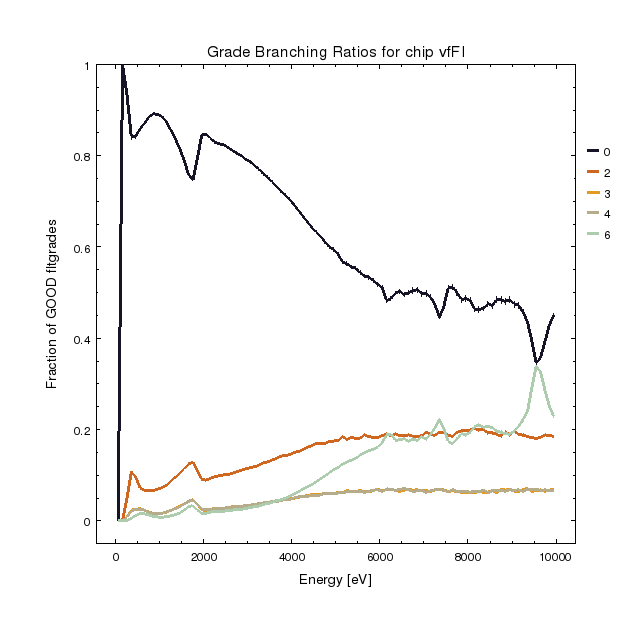

In [12]:
cat <<EOF | tee ploit_${c}.py | chips 

# Import from KJG's secret cache
import os
os.sys.path.insert( 0, "/data/da/Docs/scripts/dev/lib/python2.7/site-packages")
from chips_contrib.lut.color_curves import *
from chips_contrib.legend import *

# Load data
img = read_file("frac_${c}.img")
pix = img.get_image().values
err = read_file("frac_${c}.err").get_image().values

# '100' comes from bin size used to make images above
xlo = np.arange( pix.shape[0] )*100
xhi = xlo + 100

# Get list of grades w/ events
oo = np.sum(pix, axis=0)
fltgrades = list(set(np.arange(256)[oo>0]))
fltgrades.sort()

for gg in fltgrades: add_curve( (xlo+xhi)/2.0,  pix[:,gg], err[:,gg] )
color_curves("Colo_Coloured_sky_in")
set_curve("all", "symbol.style=none line.thickness=3")

limits(Y_AXIS, AUTO, 1 )
set_plot_xlabel("Energy [eV]")
set_plot_ylabel("Fraction of GOOD fltgrades")
set_plot_title("Grade Branching Ratios for chip ${c}")

# Add a legend
ll = Legend()
ll.label( map(str,fltgrades) )
set_current_frame(ll.frm)
reposition_frame(0.91, 0.6, 0.99, 0.8)
delete_region()
set_frame("border.visible=False")
set_current_frame("frm1")

# Save it.
print_window("ratios_${c}.png", 'export.clobber=True')
quit()
EOF

echo ""
display < ratios_${c}.png


There is a lot of good physics/structure going on here.  Note that events below 100 eV are very strongly affected by the choice of split and event thresholds  

Also grades 3 and 4 (left and right splits) almost entirely overlap.  If we were to further brake this dataset down by 
node, we would expect there to be a slightly more noticeable differance.



## BI device

Now let's replete for the BI chip


-----------------------------------------
Welcome to ChIPS: CXC's Plotting Package
-----------------------------------------
CIAO 4.8 ChIPS version 1 Thursday, December 3, 2015

chips-1> chips-1> chips-2> chips-3> chips-4> chips-5> chips-6> chips-6> chips-7> chips-8> chips-9> chips-10> chips-10> chips-11> chips-12> chips-13> chips-13> chips-14> chips-15> chips-16> chips-17> chips-17> chips-18> chips-19> chips-20> chips-20> chips-21> chips-22> chips-23> chips-24> chips-24> chips-25> chips-26> chips-27> chips-28> chips-29> chips-30> chips-31> chips-32> chips-32> chips-33> chips-34> 


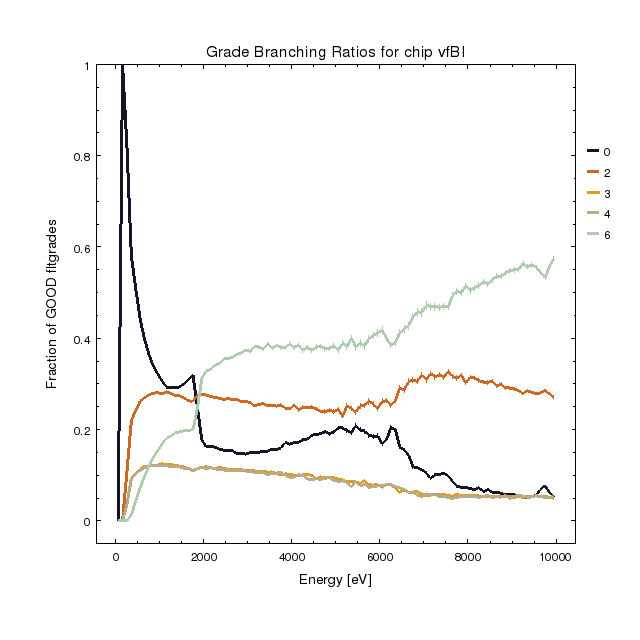

In [13]:
c="vfBI"
dmcopy "a1795_${c}_fltgrades.fits[grade=0,2,3,4,6][bin grade=0:7:1,energy=0:10000:100][opt type=i4]" ${c}.img clob+

dmimgproject ${c}.img ${c}.stats y clob+
dmimgreproject ${c}.stats"[cols y,sum]" ${c}.img ${c}.sum meth=close clob+
dmimgcalc ${c}.img ${c}.sum frac_${c}.img div clob+

dmimgcalc ${c}.img,${c}.sum none frac_${c}.err op="imgout=((img1/img2)*sqrt((1.0/img1)+(1.0/img2)))" clob+
cat <<EOF | tee ploit_${c}.py | chips 

# Import from KJG's secret cache
import os
os.sys.path.insert( 0, "/data/da/Docs/scripts/dev/lib/python2.7/site-packages")
from chips_contrib.lut.color_curves import *
from chips_contrib.legend import *

# Load data
img = read_file("frac_${c}.img")
pix = img.get_image().values
err = read_file("frac_${c}.err").get_image().values

# '100' comes from bin size used to make images above
xlo = np.arange( pix.shape[0] )*100
xhi = xlo + 100

# Get list of grades w/ events
oo = np.sum(pix, axis=0)
fltgrades = list(set(np.arange(256)[oo>0]))
fltgrades.sort()

for gg in fltgrades: add_curve( (xlo+xhi)/2.0,  pix[:,gg], err[:,gg] )
color_curves("Colo_Coloured_sky_in")
set_curve("all", "symbol.style=none line.thickness=3")

limits(Y_AXIS, AUTO, 1 )
set_plot_xlabel("Energy [eV]")
set_plot_ylabel("Fraction of GOOD fltgrades")
set_plot_title("Grade Branching Ratios for chip ${c}")

# Add a legend
ll = Legend()
ll.label( map(str,fltgrades) )
set_current_frame(ll.frm)
reposition_frame(0.91, 0.6, 0.99, 0.8)
delete_region()
set_frame("border.visible=False")
set_current_frame("frm1")

# Save it.
print_window("ratios_${c}.png", 'export.clobber=True')
quit()
EOF

echo ""
display < ratios_${c}.png


The distribution of events vs. energy for the BI chips is very different than for the FI chips. 

However, the distribution is very similar as the dataset without the vf_pha filtering applied.  

Why?  The BI devices are not thick enough to allow for large charge clouds to form.  Therefore 
the chances of change extending beyond the 3x3 island into the 5x5 is pretty small.

Why different at low energies?  That's the effect of split and event thresholds at work.

